# Denoising Autoencoder

Dies ist ein Tutorial zur Erstellung eines einfachen Denoising Autoencoders in Python mit Hilfe von Tensorflow.

Die Implementierung wurde angelehnt an [Tensorflow Project: Auto-Encoder Example](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb)

## Kurze  theoretische Einführung
Ein Denoising Autoencoder (im Folgenden _DAE_ genannt) erlernt die Fähigkeit eine korrupte Eingabe zu einem gewissen Grad wieder herzustellen.
Im Allgemeinen kann der Rekonstruktionsablauf einer Eingabe bei einem genrellen Autoencoder wie folgt beschrieben werden:
    $$x' = decode(encode(x))$$
dabei ist $x$ der Eingabevektor und $x'$ der Ausgabevektor. Ein DAE funktioniert im Gebraucht genauso, allerdings muss für das Training die Korruption manuell vorgenommen werden, und somit, der Rekonstruktionsablauf angepasst werden:
    $$x' = decode(encode(corrupt(x)))$$
dabei ist $corrupt(x)$ eine Funktion die z. B. Gaußsches Rauschen (engl. _gaussian noise_) zur Eingabe hinzufügt um sie zu korrumpiern. Der Lerneffekt erfolgt nun daraus, dass die Rekonstruktion $x'$ nicht mit $corrupt(x)$, sondern mit der originalen Eingabe $x$ verglichen wird. Diese zusätzliche Bedingung resultiert in einer robusteren Rekonstruktionsfunktion.

## Implementierung mit Tensorflow
Zu Beginn werden einige Bibliotheken importiert, mitunter Tensorflow
* **Tensorflow**: Erlaubt die einfache Realisierung von neuronalen Netzwerken
* **Numpy**: Stellt Funktionen zu sämmtlichen mathematischen Verfahren und multidimensionalen Matrizen zur Verfügung
* **Matplotlib**: Eine Bibliothek zum Erstellen von Graphen oder Anzeigen von Bildern

In [22]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Es werden allerdings auch Trainingsdaten benötigt. Für dieses Beispiel soll der DAE lernen Ziffern von 0 - 9 zu rekonstruieren. Dafür bietet sich der MNIST-Datensatz an, der über 60,000 Exemplare handgeschriebener Ziffern enthält die die Dimension 28x28 besitzen.

In [23]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Einige Voreinstellungen müssen noch gemacht werden, damit der DAE sich erwartungsgemäß funktioniert. Dafür müssen folgende Parameter initialisiert werden:
* **`learing_rate`**: Die Lernrate muss ausreichend getestet werden, da eine zu hohe Lernrate ein Umspringen der Gewichtungen zur Folge hat und kein Lerneffekt erfolgt und eine zu niedrige Lernrate den Lernprozess unnötig verlangsamt. Die Lernrate ist der Wert den der Backpropagation Algorithmus verwendet, um die Gewichte je nach Verlust anzupassen. Für dieses Beispiel bietet ein Wert zwischen 0.04 und 0.035 die besten und schnellsten Ergebnisse.
* **`num_epochs`**: Die Anzahl der Epochen die Durchlaufen werden. Eine Epoche wird erreicht, wenn einmal die gesamte Testmenge durchlaufen wurde. Für dieses Beispiel wird nach 25 - 30 Epochen ein ausreichend kleiner Verlust erreicht.
* **`batch_size`**: Die Batch Size ist die Anzahl der Trainingsdaten für die ein Verlust berechnet und eine Backpropagation durchgeführt wird. Diese sollte nicht zu hoch, allerdings auch nicht zu niedrig sein. Je nach Veränderung der Batch Size muss auch die Lernrate und die Anzahl der Epochen angepasst werden.
* **`num_display_iterations`**: Dieser Parameter dient zur Visualisierung des Lernprozesses und gibt an wie viele Iterationen ausgegeben werden sollen. Eine Iteration ist das Lernen einer Batch und gibt den Verlust aus.
* **`num_tests`**: Dieser Parameter dient ebenfalls der Visualisierung und der Überwachung des Lernfortschritts. Er gibt an wie viele Tests gemacht werden sollen. Ein Test ist so wie das Training, nur, dass hierbei die Daten aus der Testmenge anstatt der Trainingsmenge verwendet werden und die Daten nicht gelernt, sondern nur verarbeitet werden. Ein Test erfolgt nach einer ganzen Epoche. Diese Anzahl sollte vorzugsweise ein gemeinsamer Teiler von der Anzahl der Epochen sein.

In [24]:
learning_rate = 0.04
num_epochs = 25
batch_size = 200
num_display_iterations = 2
num_tests = 5

Als nächstes werden die Dimensionen der einzelnen Schichten des Netzes definiert. Wie bei einem Autoencoder üblich, ist die verdeckte Schicht von niedrigerer Dimension als die anderen. Die verdeckte Schicht kann natürlich auch eine viel höhere Dimension annehmen, mehr Neuronen zur Verfügung zu haben, die auf bestimmte Aspekte der Eingabe wert legen. Eine höhere Dimension bedeuetet allerdings auch eine deutlich erhöhte Laufzeit, was für gewöhnliche Rechner kaum tragbar wäre. Also soll das Sparsity Constraint der geringeren Anzahl von Neuronen in der verdeckten Schicht für dieses Beispiel genügen.

Des Weiteren sollte angemerkt werden, dass dieses Beispiel zwei verdeckte Schichten besitzt, aus welchem Grund es auch die beiden Parameter `num_hidden_1` und `num_hidden_2` gibt, wobei die der Wert von `num_hidden_2` die endgültige Dimension der verdeckten Schicht angibt. Diese Aufteilung in mehrere latente Repräsentionen erlaubt das Erlernen von unterschiedlichen Merkmalen, die dann von Schicht zu Schicht weiter verfeinert werden. Die Variable `num_input` beschreibt die Dimension der Eingabe- und folglich auch der Ausgabeschicht. Der Wert 784 ergibt sich aus den Dimensionen der Daten im MNIST-Datensatz, dessen Bilder die Abmessungen 28x28 besitzen, was in einer gesamten Pixelanzahl von 784 resultiert. 784 Pixel werden also in diesem Beispiel auf eine Repräsentation von nur 128 Pixel reduziert.

In [1]:
num_hidden_1 = 256
num_hidden_2 = 128
num_input = 784

Mit den Dimensionen definiert, können nun die Gewichtematrizen und die Biasvektoren erstellen. Da es zwei verdeckte Schichten gibt, besteht der Encoder, sowie der Decoder ebenfalls aus zwei Schichten. Von den Dimesnionen her wird erst von `num_input` auf `num_hidden_1` und dann auf `num_hidden_2` abgebildet und für den Decoder folglich umgekehrt. Die Matrizen und Vektoren werden mit zufälligen Werten initialisiert, indem sie durch `tf.random_normal()` die Werte einer zufälligen Normalverteilung zugewiesen bekommen.

In [26]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])), 
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

Für das manuelle Korrumpieren der Daten wird auch eine entsprechende Funktion benötigt. In diesem Beispiel wird die Eingabe mit Gaußschem Rauschen maskiert, sodass das Bild nicht mehr so leicht erkennbar ist. Dafür wird zuerst ein Rauschen `noise` erzeugt, indem auch hier wieder ein Array eier zufälligen Normalverteilung mit `np.random.normal(mean, stddev, size)` generiert wird. Der Wert für `stddev` beschreibt die Intensität des Rauschens, also je höher die Standardabweichung, desto schwerer ist das Bild zu erkennen. Für dieses Beispiel wurde der Wert 0,2 gewählt, da für höhere Werte auch deutlich mehr Epochen gebraucht werden, bis der DAE eine ordentliche Rekonstruktion lernt. Das Array `noise` wird am Schluss einfach additiv dem Eingabevektor hinzugefügt um ihn zu maskieren.

Numpy wird hier gegenüber Tensorflow bevorzugt, da die Visualisierung der korrupten Daten, also das Anzeigen als Bild am Ende des Programms damit deutlich einfacher funktioniert.

In [27]:
def corrupt(x):
    noise = np.random.normal(0, 0.2, 784)
    return x + noise

Als nächstes werden die Funktionen zum Erstellen des Encoders und des Decoders eingeführt. Als Aktivierungsfunktion der einzelnen Neuronen wird die Sigmoidfunktion verwendet. Als erstes wird der Eingabevektor `x` mit der Gewichtungsmatrix `weights['encoder_h1']` multipliziert, indem `tf.matmul()` mit beiden Parametern angewerndet wird. Dies resultiert in einem Vektor, welcher anschließend mit Hilfe von `tf.add()` mit dem Biasvektor `encoder_b1` addiert wird (Dieser Schitt wird weggelassen, sofern keine Biasvektoren verwendt werden). Dieser Ergebnisvektor wird nun in die Sigmoidfunktion `tf.nn.sigmoid()` eingegeben um die jeweiligen Aktivierungen und damit die Ausgabewerte für die erste Schicht des Encoders `layer_1` zu erhalten. Dies wird entsprechend auch für die zweite Schicht `layer_2` gemacht, welcher den endgültigen Ausgabevektor für den Encoder darstellt. Korrespondierend wird dies auch für den Decoder angewendet.

In [28]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

Um nun das Model zu konstruieren, werden die obigen Funktionen eingesetzt. 
* **`X`**: Dies ist der Eingabevektor, also auch der Eingangsvektor in diesem Tensorflow Graphen. Da es in disem Beispiel keine Funktion dafür gibt, wird hier der Eingabevektor manuell definiert, indem ein `tf.placeholder()` Array mit der Dimensionn `num_input` generiert wird. Es ist ein Placeholder, weil er zur Zeit keine Daten beinhaltet, da die Daten dynamisch von einer Trainingsmenge kommen sollen. 
* **`Z`**: Für die verdeckte Schicht `Z` kommt `enncoder()` zum Einsatz. Allerdings macht sich hier der DAE mit seiner Besonderheit bemerkbar. Anstatt die Originaldaten in den Encoder einzugeben, korrumpieren wir sie vorher, damit der DAE lernt mit korrupten Daten umzugehen.
* **`Y`**: Dies ist die Ausgabeschicht $x'$ aus der Einführung. Da dies die dekodierende Schicht ist, wird hier `decode()` verwendet, um die entsprechende Schicht zuzuweisen. Als Eingabe wird die latente Schicht `Z` verwendet, also `encode(corrupt(X))`. Damit entspricht der Aufbau des Modells (mit einer Variablenumbenennung), der obigen Definition:
    $$x' = decode(encode(x))$$
    
Zusammen ergibt dieses Model nun das neuronale Netzwerk des DAE.

Zu beachten ist, dass bei der Verwendung mit richtigen korrumpierten Daten, der Korrumptionsschritt entfernt werden muss, da die Daten nicht mehr manuell korrumpiert werden müssen.

In [29]:
X = tf.placeholder("float", [None, num_input])
Z = encoder(corrupt(X))
Y = decoder(Z) 

Das Model benötigt für das Training allerdings noch eine Verlustfunktion. In disem Beispiel ist es der mittlere quadratische Fehler. Zunächst wird der Vektor mit den Originaldaten `X` mit dem Ergebnisvektor `Y`, der die Rekonstruktion enthält, subtrahiert, um die Differenz der beiden Vektoren zu bestimmen. Anschließend wird das Ergebnis mit `tf.pow()` quadriert (die 2 gibt den Exponenten an). Danach bestimmt `tf.reduce_mean()` den Mittelwert/Durchschnitt. Diesen Verlust gilt es nun zu minimieren. Dafür stellt Tensorflow sogenannte Optimizer zur Verfügung, die durch Backpropagation das Netz aufgrund eines Verlustets bestraft. In diesem Beispiel wird die RMS Propagation mit `tf.train.RMSPropOptimizer()` verwendet. Diese nimmt als Parameter die oben definierte `learning_rate`. Da Optimizer einen Verlust zu minimieren versuchen, stellen sie auch die Funktion `minimize()` zur Verfügung, die die Verlustfunktion `loss` als Paramter bekommt.

In [30]:
# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(X - Y, 2))    #  x - x'
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

 Um alle vorher definierten Varaiblen auch zu initialisieren, also in den Tensorflow Graph aufzunehmen, müssen erst ein Initializer `tf.gloabal_varaibles_initializer()` und eine Session erzeugt werden. Mit `sess.run(init)` wird der Initializer innerhalb dieser Seesion ausgeführt.

In [31]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Nun kommt der wichtigste Teil: Das Training.

Aber zuerst werden noch folgende zwei Variablen definiert:
* **`num_iterations`**: Dies ist die _lokale_ Anzahl der Iterationen, also wie viele Iterationen es innerhalb Epoche gibt. Also ergiebt sich diese Zahl daraus, dass die Anzahl der Trainingsdaten (hier) ganzzahlig durch die Batch Size geteilt wird, da in einer Iteration eine ganze Batch Size verarbeitet wird und eine Verarbeitung als Iteration bezeichnet wird.
* **`absolute_iterations_count`**: Dies ist die _globale_ Anzahl an Iterationen, die bisher erfolgt sind.

Anschließend aber kommt das Training. Hierzu wird über die gesamte Anzahl der Epochen `num_epochs` iteriert. Eine innere Schleife iteriert über die Anzahl lokaler Iterationen `num_iterations` (aus Visualisierungsgründen wird bei beiden Schleifen ab 1 begonnen). Als Erstes werden die Trainingsdaten mit `mnist.train.next_batch(batch_size)` abgerufen und in `batch_x` gespeichert. Anschließend wird mit `sess.run` sowohl `optimizer` und `loss` mit dem Parameter `X` aufgerufen. `X` wird bei `feed_dict={}` die Testdaten in `batch_x` zugewiesen. Der Rückgabewert von `optimizer` wird nicht benötigt, allerdings der von `loss`, da dieser später ausgegeben werden soll. Dieser wird in `l` festgehalten. Die Verzweigung darunter entscheidet aufgrund von `num_display_iterations` und den vorher definierten Parametern, ob eine Kontrollausgabe gemacht werden soll. Ähnliches gilt für die Verzweigung unter der inneren Schleife, die entscheidet, ob ein Test durchgeführt werden soll. Nach der ersten Epoche wird unabhängig von `num_epochs` ein Test durchgeführt. Wenn z. B. also `num_epochs = 1`, dann wird nach der ersten und letzten Epoche ein Test durchgeführt. Dies dient allerdings auch nur zur Visialisierung und Kontrolle des Lernprozesses und hat keinen Einfluss auf die erlernten Fähigkeiten (warum es keinen Einfluss hat wird weiter unten erläutert).

Epoch 1:
	Step 137  	Loss: 0.268883
	Step 274  	Loss: 0.186099

Testing Autoencoder...
Original Images


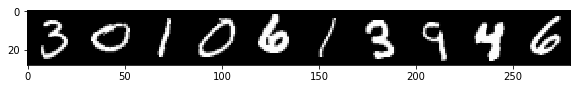

Corrupted Images


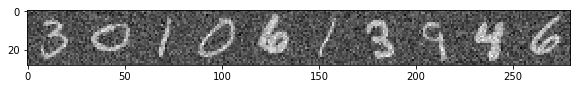

Reconstructed Images


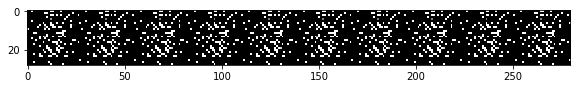

Test loss: 0.185183

Epoch 2:
	Step 412  	Loss: 0.173586
	Step 549  	Loss: 0.172772
Epoch 3:
	Step 687  	Loss: 0.172452
	Step 824  	Loss: 0.167804
Epoch 4:
	Step 962  	Loss: 0.161725
	Step 1099  	Loss: 0.160822
Epoch 5:
	Step 1237  	Loss: 0.157933
	Step 1374  	Loss: 0.153962

Testing Autoencoder...
Original Images


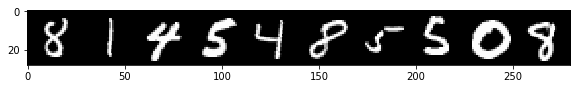

Corrupted Images


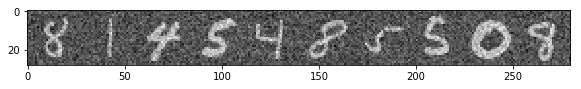

Reconstructed Images


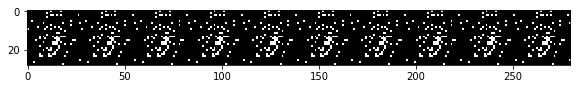

Test loss: 0.163673

Epoch 6:
	Step 1512  	Loss: 0.162197
	Step 1649  	Loss: 0.160454
Epoch 7:
	Step 1787  	Loss: 0.154815
	Step 1924  	Loss: 0.152216
Epoch 8:
	Step 2062  	Loss: 0.145053
	Step 2199  	Loss: 0.107887
Epoch 9:
	Step 2337  	Loss: 0.0891983
	Step 2474  	Loss: 0.0796972
Epoch 10:
	Step 2612  	Loss: 0.0728622
	Step 2749  	Loss: 0.0665262

Testing Autoencoder...
Original Images


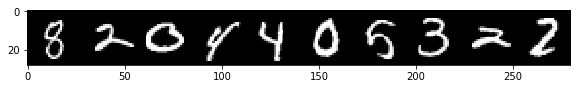

Corrupted Images


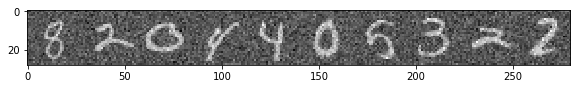

Reconstructed Images


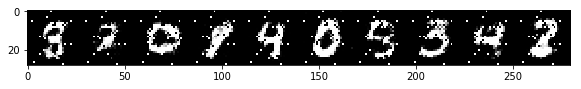

Test loss: 0.0762803

Epoch 11:
	Step 2887  	Loss: 0.0602953
	Step 3024  	Loss: 0.0573693
Epoch 12:
	Step 3162  	Loss: 0.0492915
	Step 3299  	Loss: 0.0509258
Epoch 13:
	Step 3437  	Loss: 0.0515476
	Step 3574  	Loss: 0.0493853
Epoch 14:
	Step 3712  	Loss: 0.0465737
	Step 3849  	Loss: 0.0441729
Epoch 15:
	Step 3987  	Loss: 0.0442079
	Step 4124  	Loss: 0.0473085

Testing Autoencoder...
Original Images


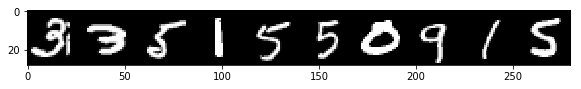

Corrupted Images


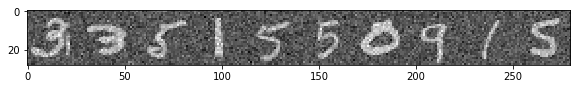

Reconstructed Images


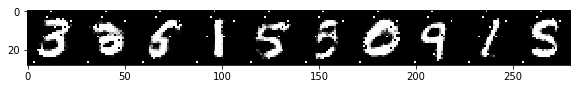

Test loss: 0.0481546

Epoch 16:
	Step 4262  	Loss: 0.0457397
	Step 4399  	Loss: 0.0417459
Epoch 17:
	Step 4537  	Loss: 0.044523
	Step 4674  	Loss: 0.0424515
Epoch 18:
	Step 4812  	Loss: 0.0425358
	Step 4949  	Loss: 0.0396248
Epoch 19:
	Step 5087  	Loss: 0.0408091
	Step 5224  	Loss: 0.0400259
Epoch 20:
	Step 5362  	Loss: 0.0407486
	Step 5499  	Loss: 0.0387827

Testing Autoencoder...
Original Images


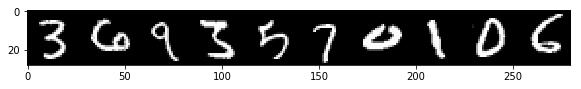

Corrupted Images


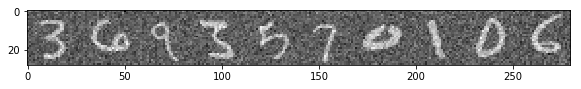

Reconstructed Images


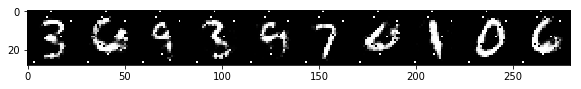

Test loss: 0.0414598

Epoch 21:
	Step 5637  	Loss: 0.0385437
	Step 5774  	Loss: 0.0420048
Epoch 22:
	Step 5912  	Loss: 0.0393609
	Step 6049  	Loss: 0.0347449
Epoch 23:
	Step 6187  	Loss: 0.0385361
	Step 6324  	Loss: 0.0383859
Epoch 24:
	Step 6462  	Loss: 0.0370257
	Step 6599  	Loss: 0.03612
Epoch 25:
	Step 6737  	Loss: 0.037347
	Step 6874  	Loss: 0.0360186

Testing Autoencoder...
Original Images


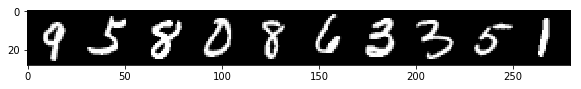

Corrupted Images


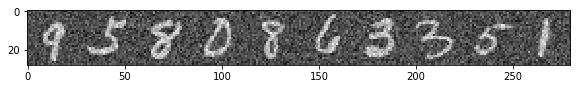

Reconstructed Images


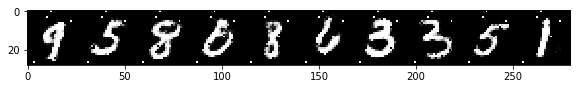

Test loss: 0.0329462



In [33]:
num_iterations = mnist.train.num_examples // batch_size
absolute_iterations_count = 1    

for epoch in range(1, num_epochs + 1):
    print("Epoch " + str(epoch) + ":")

    for i in range(1, num_iterations + 1):
        batch_x, _ = mnist.train.next_batch(batch_size)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        
        if i % (num_iterations // num_display_iterations) == 0:
            print("\tIteration " + str(absolute_iterations_count) + "  \tLoss: " + str(l))

        absolute_iterations_count += 1
            
    if epoch % (num_epochs // num_tests) == 0 or epoch == 1:
        testAE()

Was nun noch fehlt ist die Testfunktion, die beim obigen Training verwendet wurde. Wie bereits erläutert dient das Testen der Kontrolle, um zu prüfen, wie gut das Netz bei Eingaben arbeitet, die er nicht trainiert hat.

Da dieser Teil ein wenig mit dem Testen an sich und der Visualisierung des Testablaufes vermischt ist, wird er in zwei Erläuterungsschritte aufgeteilt. Die entsprechenden Codestellen wurden mit _`Testing`_ und _`Visualization`_ markiert.

### Testen
Zunächst wird eine Variable `n` angelegt, die angibt, wie viele Daten getestet werden sollen, also im Grunde die Batch Size für den Test. Als nächstes werden, ähnlich wie bei dem Training auch, die Testdaten mit `mnist.test.next_batch(n)` abgerufen und in `batch_x` gespeichert. Der Hauptunterschied zwischen Test und Training erfolt hier: Es wird mit `sess.run()` **nur** `loss` mit den Testdaten aus `batch_x` aufgerufen. Der Optimizer wird weggelassen, da die Testdaten nicht trainiert werden sollen und nur der Verlust bestimmt wird. Diesen Verlust können wir nun ausgeben um zu sehen, ob das Netz schlechter oder sogar besser mit unbekannten Daten arbeitet (in der Regel ist der Test wert ein wenig schlechter als der Trainingswert).

### Visualisierung
Zu Beginn werden drei Numpy-Arrays erstellt `canvas_orig`, `canvas_corrupt` und `canvas_recon`, mit den Dimensionen 28x(28\*n). Diese Abmessung kommt zu Stande, da die Testdaten (wie bei dem Training auch) 28x28 Pixel groß sind. In diesem Beispiel werden die 10 Testbilder (da `n = 10`) in einer Reihe nebeneinander angezeigt, somit benötigen wir `28` Pixel in der Y-Achse und `28 * n` Pixel in der X-Achse. Als nächste werden die rekonstruierten Bilder benötigt, die angezeigt werden sollen. Dafür wird die Berechnung des Verlustes aus dem Testen-Teil verwendet, indem `Y` auch mit `sess.run()` mit den Testdaten aus `batch_x` aufgerufen wird. Dies liefert die direkte Ausgabe des DAE und speichern sie in `g`. Nun liegen die Daten in einem eindimensionalen Array mit der Größe 748 (28 \* 28) vor, die jeweils noch umgeformt werden müssen. In einer Schleife wird über die Anzahl der Testdaten `n` iteriert um jedes Bild einzeln zu verarbeiten. Das Array `canvas_orig` soll das Originalbild enthalten, also wird mit `batch_x[i].reshape([28, 28])` das i-te Bild aus `batch_x` in die Form 28x28 Pixel gebracht und dann 'canvas_orig' an entsprechender Stelle (abhängig von `i`) zugewiesen. Für `canvas_corrput`, welches die korrupten Bilder enthalten soll, gilt selbiges mit der Ausnahme, dass das Bild aus `batch_x[i]` erst durch `corrupt()` korrumpiert werden muss. Mit `canvas_recon` wird ebenfalls entsprechend für die rekonstruierten Bilder verfahren, welche sich in `g` befinden. Zum Schluss werden die Bilder noch ausgegeben. Dazu wird Matplotlib (hier `plt`) verwendet. Für die Ausgaben werden die Parameter `origin="upper"` und `cmap="gray"` verwendet. Ersteres beschreibt, wo die Koordinate `[0, 0]` für das Array ist, aus dem das Bild gezeichnet werden soll. Da unser Array an der ersten Stelle den ersten Pixel oben links hat, wird hier `upper` verwendet. Letzteres wird verwendet, um das Bild schwarzweiß gefärbt.

In [32]:
def testAE():
    # Testing
    n = 10
    
    # Visualization
    canvas_orig = np.empty((28, 28 * n))
    canvas_corrupt = np.empty((28, 28 * n))
    canvas_recon = np.empty((28, 28 * n))
    
    # Testing
    batch_x, _ = mnist.test.next_batch(n)
    
    # Testing and Visualization
    g, l = sess.run([Y, loss], feed_dict={X: batch_x})

    # Visialization
    for i in range(n):
        canvas_orig[0: 28, i * 28: (i + 1) * 28] = batch_x[i].reshape([28, 28])
        canvas_corrupt[0: 28, i * 28: (i + 1) * 28] = corrupt(batch_x[i]).reshape([28, 28])
        canvas_recon[0: 28, i * 28: (i + 1) * 28] = g[i].reshape([28, 28])    
    
    # Visualization
    print("Original Images")     
    plt.figure(figsize=(n, 1))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()
    
    print("Corrupted Images")     
    plt.figure(figsize=(n, 1))
    plt.imshow(canvas_corrupt, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, 1))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()
    
    print("Test loss: " + str(l) + "\n")

Somit erhalten wir einen voll funktionsfähigen Denoising Autoencoder. Zu beachten ist allerdings, dass die Funktion `testAE()` vor dem Training stehen muss (oder hier im Jupyter Notebook vorher aktiviert werden muss), da das Programm diese Funktion zum Zeitpunkt des Trainings noch nicht kennt. Allerdings wurde sie aus Anschaulichkeitsgründen erst nach dem Training erläutert.